In [1]:
import tensorflow as tf
import cProfile

# 一. 即刻执行
## 1. Eager训练
### (1) 计算梯度

In [2]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
    loss = w * w

grad = tape.gradient(loss, w)
grad

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.]], dtype=float32)>

### (2) 训练模型

Logits:  [[-0.01164776  0.00152341  0.01588978  0.00799478  0.00802848  0.00218358
  -0.01569655  0.01052542  0.02027918  0.0209105 ]]
Epoch 0 finished
Epoch 1 finished
Epoch 2 finished


Text(0, 0.5, 'Loss [entropy]')

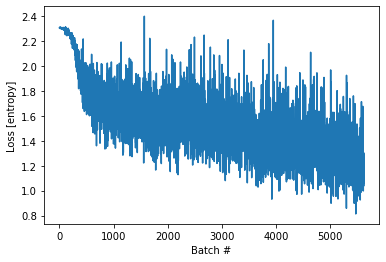

In [22]:
# 获取并打乱数据
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(mnist_images[..., tf.newaxis]/255, tf.float32),
    tf.cast(mnist_labels, tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

# 构建模型
mnist_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, [3, 3], activation='relu',
                          input_shape=(None, None, 1)),
    tf.keras.layers.Conv2D(16, [3, 3], activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])

# 调用模型，检查输出
for images, labels in dataset.take(1):
    print("Logits: ", mnist_model(images[0:1]).numpy())
    
# 定义优化器和损失函数
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

# 定义训练过程
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)
        tf.debugging.assert_equal(logits.shape, (32, 10))
        loss_value = loss_object(labels, logits)
    
    loss_history.append(loss_value.numpy().mean())
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))
    
# 训练
def train(epochs):
    for epoch in range(epochs):
        for (batch, (images, labels)) in enumerate(dataset):
            train_step(images,labels)
        print('Epoch {} finished'.format(epoch))

train(epochs=3)

# 绘制loss曲线
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')


### (3) 模型保存

In [26]:
x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x)

x.assign(2.0)
checkpoint_path = './ckpt/'
checkpoint.save(checkpoint_path)

x.assign(11.)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))
x

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>

In [30]:
import os

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint_dir = './ckpt_mnist'
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model)

root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [34]:
# metrics存储
m = tf.keras.metrics.Mean('loss')
m(0)
m(5)
print(m.result())
m([8, 9])
print(m.result())

tf.Tensor(2.5, shape=(), dtype=float32)
tf.Tensor(5.5, shape=(), dtype=float32)


### (4) 摘要

In [36]:
# summary可以记录每轮训练的摘要
logdir = './tb/'
writer = tf.summary.create_file_writer(logdir)

steps = 1000
with writer.as_default():
    for i in range(steps):
        step = i + 1000
        loss = 1 - 0.001 * step
        if step % 100 == 0:
            tf.summary.scalar('loss', loss, step=step)